In [1]:
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/My Drive/lab/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

# Auther: Seongwoo Kim
#한 이미지 내의 숫자가 몇개 있는지 세는 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
import torch.utils.model_zoo as model_zoo



USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS     = 40
BATCH_SIZE = 60

img_size = 224              #인풋으로 받는 이미지의 크기

transform = transforms.Compose([
    transforms.ToTensor()
])
custom_transform = transforms.Compose([
    #transforms.RandomRotation(15),
    transforms.Normalize((0.1307,),(0.3881,)),
    
])

trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform,
)


train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)


def find_contour(img):
  Img = (img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  W, H = 28, 28
  Img_size = W * H
  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  group = list()
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.0008 and area < Img_size * 0.8 and hierachy[0,n,3] == -1):
          group.append((area, n))
  group.sort()
  if(len(group)== 0):
    print('error')
    return torch.zeros(1,28,28)
  x, y, w, h = cv2.boundingRect(contours[group[-1][1]])
  return img[:,y:y+h,x:x+w]

def resizing(t, y, x):
  _,_,height,width = t.shape
  res = torch.zeros(1,1,y,x).to(DEVICE)
  if(height/width > y/x):
    t = F.interpolate(t, size=(y, round(width * y / height)), mode='area')
    _,_,height,width = t.shape
    res[:,:,:,0:width].add_(t)
  else:
    res = F.interpolate(t, size=(y, x), mode='area').to(DEVICE)
  return res

class CustomDataset(Dataset):                                                   #1~4개의 숫자 그림을 MNIST에서 받아서 한 이미지 내에 넣은 데이터셋 생성 
    def __init__(self, loader, transform=None):
        data_total = len(loader)*BATCH_SIZE                                     #60000
        self.transform = transform
        self.x_data = torch.zeros(data_total*4//10,1,img_size,img_size*3//2).to(DEVICE)
        self.y_data = torch.zeros(data_total*4//10,1,dtype=int).to(DEVICE)
        for batch_idx, (data, target) in enumerate(loader):                     #data는 [50,1,28,28]
            data, target = data.to(DEVICE), target.to(DEVICE)
            if(batch_idx * BATCH_SIZE < data_total//10):                        #숫자가 1개 있는 샘플
                points_num = 1  
            elif(batch_idx * BATCH_SIZE < data_total*3//10): 
                points_num = 2                               #숫자가 2개 있는 샘플
            elif(batch_idx * BATCH_SIZE < data_total*6//10):
                points_num = 3                               #숫자가 3개 있는 샘플
            else:
                points_num = 4                               #숫자가 4개 있는 샘플
            for count in range(BATCH_SIZE):
                if(count%points_num == 0):      
                    x_position = 0
                    image_list = list()               
                    padding_sum = random.randrange(0,70)
                up_padding = random.randrange(0,padding_sum+1)
                down_padding = padding_sum - up_padding
                image_cut = find_contour(data[count,:,:,:]).to(DEVICE)
                _, Y, X = image_cut.shape
                image_cut = F.interpolate(image_cut.unsqueeze(0), size=(img_size, round(img_size * X / Y)), mode='area')
                image_cut = torch.cat((torch.zeros(1,1,up_padding,round(img_size * X / Y)).to(DEVICE), image_cut), dim=2)
                image_cut = torch.cat((image_cut, torch.zeros(1,1,down_padding,round(img_size * X / Y)).to(DEVICE)), dim=2)
                image_list.append((x_position,round(img_size * X / Y), image_cut))
                x_position += round(img_size * X / Y)
                if((count+1)%points_num == 0):
                    ratio = random.random()*0.15 + 0.85
                    tmp_tensor = 	torch.zeros(1,1,img_size+padding_sum,round(image_list[-1][0]*ratio)+image_list[-1][1]).to(DEVICE)
                    for idx in range(points_num):
                      tmp_tensor[:,:,:,round(image_list[idx][0]*ratio):round(image_list[idx][0]*ratio)+image_list[idx][1]].add_(image_list[idx][2])                      
                    tmp_tensor = torch.clamp(resizing(tmp_tensor,img_size,img_size*3//2),0,1)
                    self.x_data[data_total//20 * (points_num - 1) + (batch_idx * BATCH_SIZE + count) // points_num,:,:,:].add_(tmp_tensor.squeeze())
                    self.y_data[data_total//20 * (points_num - 1) + (batch_idx * BATCH_SIZE + count) // points_num].add_(points_num-1)
    def __len__(self):
        return self.x_data.shape[0]
    def __getitem__(self, idx):
        x = self.x_data[idx,:,:,:]
        if self.transform:
            x = self.transform(x)
        return x, int(self.y_data[idx,0])

custom_dataset = CustomDataset(train_loader, transform = custom_transform)
custom_trainset, custom_testset = torch.utils.data.random_split(custom_dataset, [20000, 4000])

custom_train_loader = torch.utils.data.DataLoader(
    dataset     = custom_trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

custom_test_loader = torch.utils.data.DataLoader(
    dataset     = custom_testset,
    batch_size  = BATCH_SIZE,
)

Extracting ./.data/MNIST/raw/train-images-idx3-ubyte.gz to ./.data/MNIST/raw


Extracting ./.data/MNIST/raw/train-labels-idx1-ubyte.gz to ./.data/MNIST/raw


Extracting ./.data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/MNIST/raw


Extracting ./.data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


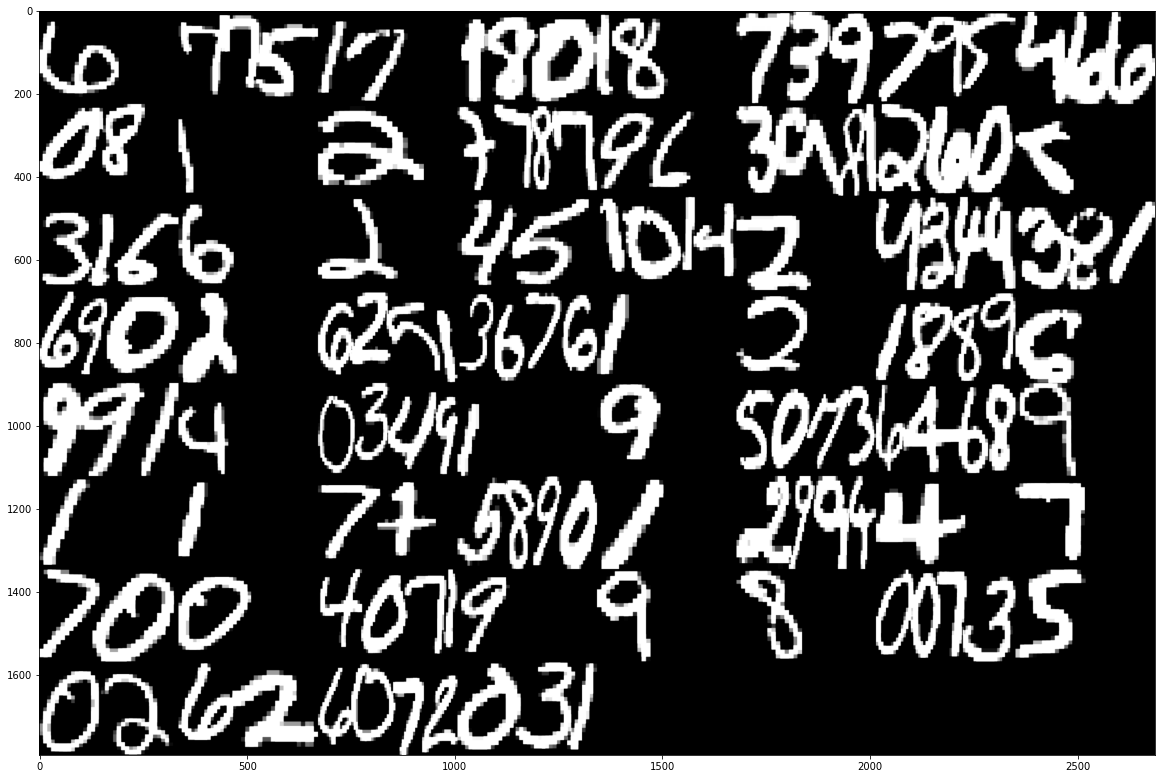

0 2 1 2 1 2 2 2 1 0 0 3 1 3 2 0 2 0 0 1 3 0 3 2 2 0 3 3 0 0 3 0 2 0 3 0 0 3 3 0 0 0 1 3 0 3 0 0 1 0 3 0 0 0 3 0 1 1 3 2 

In [3]:
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

dataiter       = iter(custom_train_loader)
images, labels = next(dataiter)

img   = utils.make_grid(images, padding=0).cpu()
npimg = img.numpy()
plt.figure(figsize=(20, 14))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
CLASSES = {
    0: '1',
    1: '2',
    2: '3',
    3: '4'

}
for label in labels:
    index = label.item()
    print(index, end=' ')

In [0]:

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return F.log_softmax(x, dim=1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}
conv = make_layers(cfg['A'], batch_norm=True)

model = VGG(make_layers(cfg['A']), num_classes=4, init_weights=True).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#MNIST 데이터셋을 이용해 학습 진행
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# ## 테스트하기

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [5]:
for epoch in range(1, EPOCHS + 1):
    train(model, custom_train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, custom_test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/20000 (0%)]	Loss: 1.386834
Train Epoch: 1 [6000/20000 (30%)]	Loss: 0.743649
Train Epoch: 1 [12000/20000 (60%)]	Loss: 0.694546
Train Epoch: 1 [18000/20000 (90%)]	Loss: 0.539696
[1] Test Loss: 0.2875, Accuracy: 88.65%
Train Epoch: 2 [0/20000 (0%)]	Loss: 0.367525
Train Epoch: 2 [6000/20000 (30%)]	Loss: 0.190624
Train Epoch: 2 [12000/20000 (60%)]	Loss: 0.296348
Train Epoch: 2 [18000/20000 (90%)]	Loss: 0.175280
[2] Test Loss: 0.2001, Accuracy: 91.92%
Train Epoch: 3 [0/20000 (0%)]	Loss: 0.579257
Train Epoch: 3 [6000/20000 (30%)]	Loss: 0.120847
Train Epoch: 3 [12000/20000 (60%)]	Loss: 0.106983
Train Epoch: 3 [18000/20000 (90%)]	Loss: 0.319850
[3] Test Loss: 0.2649, Accuracy: 89.92%
Train Epoch: 4 [0/20000 (0%)]	Loss: 0.311675
Train Epoch: 4 [6000/20000 (30%)]	Loss: 0.211398
Train Epoch: 4 [12000/20000 (60%)]	Loss: 0.091693
Train Epoch: 4 [18000/20000 (90%)]	Loss: 0.270151
[4] Test Loss: 0.1491, Accuracy: 94.38%
Train Epoch: 5 [0/20000 (0%)]	Loss: 0.151789
Train Epoch: 5 [600

In [6]:
torch.save(model.state_dict(), directory_path + 'VGG_count_model.pt')
new_model = VGG(make_layers(cfg['A']), num_classes=4, init_weights=True).to(DEVICE)
new_model.load_state_dict(torch.load(directory_path + 'VGG_count_model.pt'))
for epoch in range(1):
    test_loss, test_accuracy = evaluate(new_model, custom_test_loader)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[0] Test Loss: 0.0900, Accuracy: 98.03%
